In [ ]:
import numpy as np
import struct
from array import array
from os.path import join
import pandas as pd
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Classifying MNIST Images With Various Neural Networks and Comparing Them
- Thomas Armstrong
- Approved by Max

## Neural Networks Used
- Dense
- Convolutional

In this tutorial, we'll be using a dense neural network and a convolutional neural network in order to classify MNIST images, and then comparing the results of the networks. 








## What are MNIST Images?

---


MNIST images are images of handwritten digits ranging from 0-9. The images are in 28 by 28 pixels, and are greyscale only, with a completely black background. There will also be some example images printed below, if this description is inadequate.

This makes MNIST images great to use for machine learning. Images being greyscaled means that each pixel can be represented by one value, from 0 to 255. Then, the full representation of an MNIST image can be thought of as a 28x28 array. Values within the array would have values up to 255, indicating the pixel is completely white, and as low as 0, indicating the completely black background.

# Data Collection

---

I found the MNIST data available from Kaggle [here](https://www.kaggle.com/datasets/hojjatk/mnist-dataset?resource=download).

The user that posted the MNIST data also generously provided code to read in the data, which I found [here](https://www.kaggle.com/code/hojjatk/read-mnist-dataset/notebook).


This allowed for a very simple data collection process, where I simply had to download the data myself, and direct the code to the proper file directory. 

In this notebook, I will be saving all of the data and saved models to my Google Drive.

In [ ]:
file_dir = "./drive/MyDrive/College/CMSC320/mnist/"

MNIST Data from: https://www.kaggle.com/datasets/hojjatk/mnist-dataset?resource=download

Code for reading the data: https://www.kaggle.com/code/hojjatk/read-mnist-dataset/notebook



In [ ]:


#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)




#
# Set file paths based on added MNIST Datasets
#
input_path = file_dir
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')


#
# Load MNIST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Preparing Data for Model Input

---

Currently, each image is an array of 28 arrays. Generally, when passing the inputs into the model, we want each image to instead be a 2D array.

This way, we pass an array of 2D arrays into the model, instead of an array of arrays of arrays.

The model will expect each input to have a specific shape (in this case 28x28), which is difficult to determine when an input is an array of arrays.

Here, you can see that each image is currently an array of arrays. This can be seen by the multiple array declarations instead of a single array declaration.

In [ ]:
x_train[0]

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=uint8),
 array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0], dtype=uint8),
 array([  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170,
        253, 253, 253, 253, 253, 225, 172, 253, 242, 195,  64,   0,   0,
          0,   0], dtype=uint8),
 array([  0,   0,   0,   0,   0,   0,   0,  49, 238, 253, 253, 253,

To convert the inputs into 2D arrays, we can use the [numpy stack function](https://numpy.org/doc/stable/reference/generated/numpy.stack.html):

In [ ]:
x_train = np.stack(x_train)
y_train = np.stack(y_train)
x_test = np.stack(x_test)
y_test = np.stack(y_test)

Note that we even stack our labels. Although not as necessary, it keeps the datatypes uniform.

Now, each input image is a 2D array:

In [ ]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

## Creation of Validation Dataset

---

Currently, we have a train and a test dataset. I will also be creating a third validation set, that we will use during training to evaluate the model's performance on data it hasn't seen.

- Train set: Used for training our models
- Validation set: Used to validate the models during training
- Test set: Used to evaluate our models' predictions after training

This is useful because we are essentially double blinded to the test set before analysis. We've never seen any of the data within the set, and do not know how the model will perform with it.

If we did not create a separate validation set, we would no longer be blinded to the test set, as we would use the test set during validation in model training.

We'll be using sklearn's [train_test_split function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1667, random_state=42)

# Showing Example Images

---

The following code is used to show some example images from the dataset. It also came from [Kaggle](https://www.kaggle.com/code/hojjatk/read-mnist-dataset/notebook) as a part of data collection.

In [ ]:
#
# Helper function to show a list of images with their relating titles
#
%matplotlib inline
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(20,10))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

By showing random sample images, we can see that the digits are not exactly the same. There is quite a bit of variation within digits.

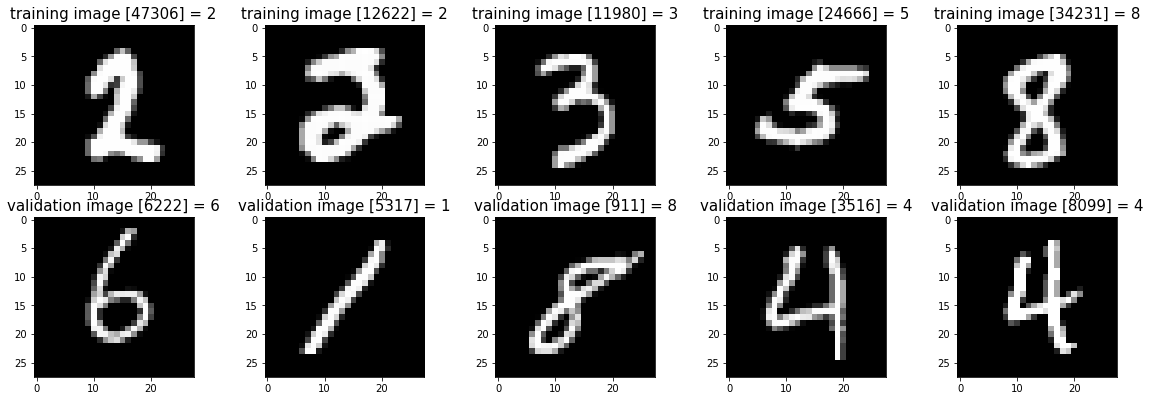

In [ ]:
#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 5):
    r = random.randint(1, len(x_train))
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, len(x_valid))
    images_2_show.append(x_valid[r])        
    titles_2_show.append('validation image [' + str(r) + '] = ' + str(y_valid[r]))    

show_images(images_2_show, titles_2_show)

As you can see, each image is 28x28 and in black and white. 

# Initial Data Analysis

---

To ensure that there is no classification bias in the models, we should aim to have close to the same amount of each label present the training set.

To check how many of each label we have, we'll make use of Numpy's [bincount function](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html). This function takes an array of numbers, and returns an array where the indexes represent the numbers from the original array, and the values at each index are the number of occurrences.

So, for example:
```
initial_array = np.array([0, 1, 2, 2, 2, 3, 3])
bincounted_array = np.bincount(initial_array)

bincounted_array[0] = 1
bincounted_array[1] = 1
bincounted_array[2] = 3
bincounted_array[3] = 2
```

Another useful function is Numpy's [ptp function](https://numpy.org/doc/stable/reference/generated/numpy.ptp.html). This stands for peak-to-peak, and calculates the largest possible range from an array of values.

Average number of inputs per label: 4999.8
Standard deviation of inputs per label: 278.88700220698706
Range of inputs per label: 5649 - 4501 = 1148


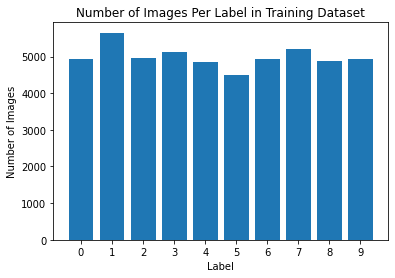

In [ ]:
bincount = np.bincount(y_train)
print(f"Average number of inputs per label: {bincount.mean()}")
print(f"Standard deviation of inputs per label: {bincount.std()}")
print(f"Range of inputs per label: {bincount.max()} - {bincount.min()} = {np.ptp(bincount)}")

plt.title("Number of Images Per Label in Training Dataset")
plt.ylabel("Number of Images")
plt.xlabel("Label")
plt.bar(range(0, 10), bincount)
plt.xticks(range(0, 10))
plt.show()

Overall, there is not a huge difference in number of images per label. The lowest number of images is 4501 for the label 5, and the highest number of images is 5649 for the label 1. Each of these are about two standard deviations off of the mean.

This is likely not a huge enough difference to cause significantly harmful effects to our models during training.

Average number of inputs per label: 1000.2
Standard deviation of inputs per label: 44.94619004988076
Range of inputs per label: 1093 - 920 = 173


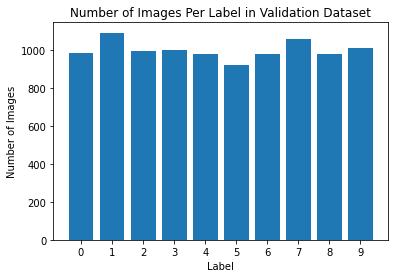

In [ ]:
bincount = np.bincount(y_valid)
print(f"Average number of inputs per label: {bincount.mean()}")
print(f"Standard deviation of inputs per label: {bincount.std()}")
print(f"Range of inputs per label: {bincount.max()} - {bincount.min()} = {np.ptp(bincount)}")

plt.title("Number of Images Per Label in Validation Dataset")
plt.ylabel("Number of Images")
plt.xlabel("Label")
plt.xticks(range(0, 10))
plt.bar(range(0, 10), bincount)
plt.show()

Although not as important to check since it won't affect training, the validation dataset also has a decent number of images for each class.

# Creating a Dense Neural Network

---



For this step, we're just going to make a densely connected neural network that takes the images as inputs, and returns an array of size 10, corresponding to the number of digits, where each value is the probability of the image being the digit associated with the index.

An example output may look like: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

This can be seen in the model from the last layer we add, the Dense layer of size 10, with softmax activation.


This would indicate the model is predicting the digit 3, since the probability in the index 3 is as high as possible.


For the models in this notebook, I'll primarily be using TensorFlow and Keras. If you're new to TensorFlow, there's some tutorials [here](https://www.tensorflow.org/tutorials) that can get you started.

In [ ]:
d_model = Sequential()
d_model.add(Flatten(input_shape=(28, 28, 1)))
d_model.add(Dense(32, activation='relu'))
d_model.add(Dense(16, activation='relu'))
d_model.add(Dense(10, activation='softmax'))

d_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 10)                170       
                                                                 
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0
_________________________________________________________________


Since we're passing the digit numbers into the model as our labels instead of one-hot encoded vectors, we use sparse categorical crossentropy instead of normal categorical crossentropy.

In [ ]:
d_model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Here we create Keras' [EarlyStopping callback](https://keras.io/api/callbacks/early_stopping/). 

This will stop the model from training further when the model goes 1 epoch without a decrease in validation loss (the patience). Typically, we want to implement some kind of early stopping mechanism like this so that our model does not overfit to the training data. 

Although we could just reduce the number of epochs, this approach would prevent us from reaching the best model possible, as training could end before reaching our best accuracy.

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

Below is the code that was used to generate our model. Note that you may receive different results when running this section over again. Therefore, I have saved a model that we will instead use for analysis as otherwise I would be doing new analysis on a model each time I had to run this code (which would be a lot of times as I reconnect to Google Colab's runtime).

In [ ]:
d_history = d_model.fit(x=x_train, y=y_train,
                    validation_data=(x_valid, y_valid),
                    epochs=50,
                    callbacks=[callback])

Epoch 1/50
1563/1563 [==============================] - 3s 2ms/step - loss: 1.9037 - accuracy: 0.6142 - val_loss: 0.8486 - val_accuracy: 0.7244
Epoch 2/50
1563/1563 [==============================] - 2s 2ms/step - loss: 0.7127 - accuracy: 0.7707 - val_loss: 0.5500 - val_accuracy: 0.8490
Epoch 3/50
1563/1563 [==============================] - 2s 2ms/step - loss: 0.4930 - accuracy: 0.8709 - val_loss: 0.4873 - val_accuracy: 0.8840
Epoch 4/50
1563/1563 [==============================] - 2s 2ms/step - loss: 0.4089 - accuracy: 0.8960 - val_loss: 0.4054 - val_accuracy: 0.8949
Epoch 5/50
1563/1563 [==============================] - 2s 2ms/step - loss: 0.3637 - accuracy: 0.9072 - val_loss: 0.3825 - val_accuracy: 0.9094
Epoch 6/50
1563/1563 [==============================] - 3s 2ms/step - loss: 0.3317 - accuracy: 0.9148 - val_loss: 0.3545 - val_accuracy: 0.9149
Epoch 7/50
1563/1563 [==============================] - 2s 2ms/step - loss: 0.3002 - accuracy: 0.9212 - val_loss: 0.3453 - val_accuracy:

This is the code to save the model and it's history. It's commented out so that the model is not overwritten each runthrough of the notebook. This allows our data analysis to be a bit more standardized.

In [ ]:
'''
d_model.save("./drive/MyDrive/College/CMSC320/saved_model/dnn", overwrite=True)

hist_df = pd.DataFrame(d_history.history)
with open("./drive/MyDrive/College/CMSC320/saved_model/dnn_history.csv", mode='w') as f:
    hist_df.to_csv(f)
'''

'\nd_model.save("./drive/MyDrive/College/CMSC320/saved_model/dnn", overwrite=True)\n\nhist_df = pd.DataFrame(d_history.history)\nwith open("./drive/MyDrive/College/CMSC320/saved_model/dnn_history.csv", mode=\'w\') as f:\n    hist_df.to_csv(f)\n'

In [ ]:
# Loading pretrained model for standardized results and analysis for when Colab dies

d_model = load_model("./drive/MyDrive/College/CMSC320/saved_model/dnn")
d_history = pd.read_csv("./drive/MyDrive/College/CMSC320/saved_model/dnn_history.csv")

# Evaluating Dense Neural Network Training

---


313/313 - 0s - loss: 0.3627 - accuracy: 0.9038 - 389ms/epoch - 1ms/step


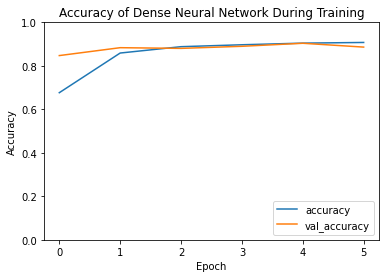

In [ ]:
plt.plot(d_history['accuracy'], label='accuracy')
plt.plot(d_history['val_accuracy'], label = 'val_accuracy')
plt.title("Accuracy of Dense Neural Network During Training")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = d_model.evaluate(x_valid,  y_valid, verbose=2)

Here we can see the training accuracy and validation accuracy begin to converge after about 1 epoch.

As expected, our validation accuracy decreased at the end of training. This is a result of our EarlyStopping callback from earlier - training will stop when the model begins to perform worse than previously.

Fortunately though, thanks to setting `restore_best_weights=True` in the callback, the model returns to the weights from the epoch before validation loss began to increase.


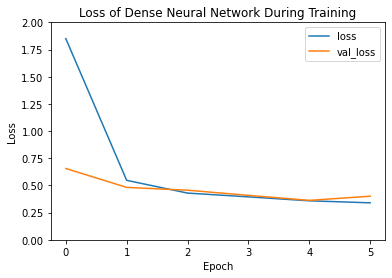

In [ ]:
plt.plot(d_history['loss'], label='loss')
plt.plot(d_history['val_loss'], label = 'val_loss')
plt.title("Loss of Dense Neural Network During Training")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')
plt.show()

Like the accuracy graph, the loss graph also indicates the model was beginning to experience some overfitting at the end of training, as the validation loss began to increase.

# Evaluating Dense Neural Network Predictions

---



One important way to evaluate the model is to see how its number of predictions vary from the true number of digits.

Using the test dataset, we will get the model's predictions, and then compare the two. We also make use of Numpy's [argmax function](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html), which returns the index of the largest value in an array. 

In this case, that will get us an exact prediction from the model in single digit form.

In [ ]:
y_test_preds = np.argmax(d_model.predict(x_test), axis=1)

313/313 [==============================] - 0s 1ms/step


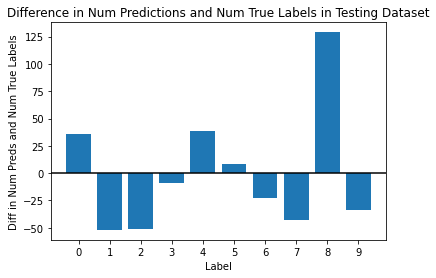

In [ ]:
pred_bincount = np.bincount(y_test_preds)
truth_bincount = np.bincount(y_test)
plt.title("Difference in Num Predictions and Num True Labels in Testing Dataset")
plt.ylabel("Diff in Num Preds and Num True Labels")
plt.xlabel("Label")
plt.xticks(range(0, 10))
plt.gca().axhline(y=0, color="black")
plt.bar(range(0, 10), pred_bincount - truth_bincount)
plt.show()

In the above graph, we're comparing the difference in number of predictions versus the number of true labels for each digit in the test set.

Positive values indicate more predictions than actual labels for that digit.



As it turns out, our model is significantly overclassifying things as the digit 8, and underclassifying things as the digits 1 and 2.

One possible improvement that could be made to the network could be to add some dropout layers. This could help ensure the nodes in the network learn different features, instead of multiple nodes learning similar features from the digits. This could possibly allow the model to learn more significant features from the digits 1 and 2, improving our underclassification.

---
We should also look into how the model is misclassifying results. We know that we're underclassifying 1 and 2 and overclassifying 8, but how? What true digits are being predicted into what labels?


To start, we'll make a confusion matrix that shows where our true digits are ending up. I found [this resource](https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/) to be quite helpful to learn how to make a confusion matrix.



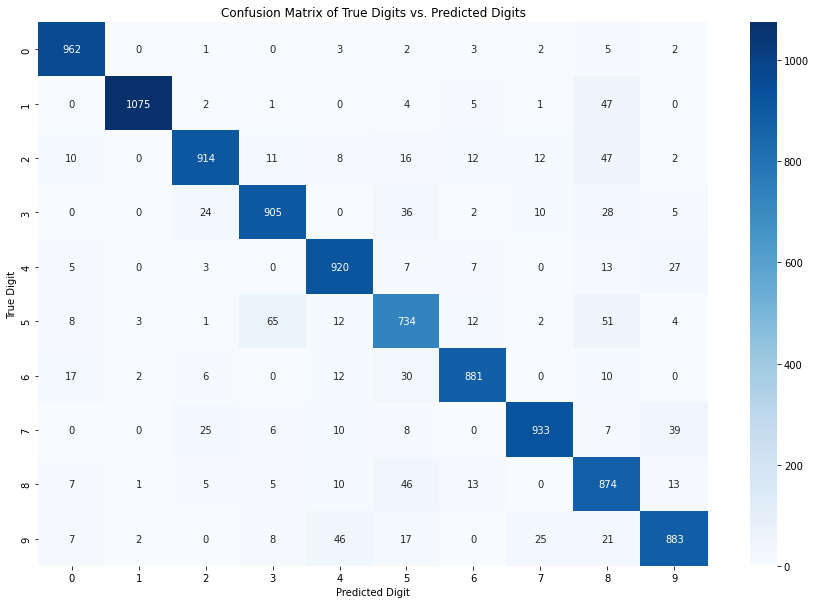

In [ ]:
cf_matr = confusion_matrix(y_test, y_test_preds)

ax = sns.heatmap(cf_matr, annot=True, fmt='0', cmap='Blues')
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(15)

ax.set_ylabel("True Digit")
ax.set_xlabel("Predicted Digit")
ax.set_title("Confusion Matrix of True Digits vs. Predicted Digits")
plt.show()

From the confusion matrix, we can see that we're often predicting 1 and 2 as 8s. This would explain why we were often underclassifying 1 and 2, while overclassifying 8.

We can also see that we're predicting:
- 5s as 3s
- 5s as 8s
- 8s as 5s
- 9s as 4s


Although, to be honest, I find it hard to gain insights from a confusion matrix this big.
So, we'll also make some bar graphs of the misclassifications.

---

To start, we'll make a dictionary where each key represents the true labels, and the values will store lists with what the model predicted the key to be.

In [ ]:
misclassifications = {}
for i in range(len(y_test)):
    true_label = y_test[i]
    pred_label = y_test_preds[i]

    if true_label != pred_label:
        misclassifications.setdefault(true_label, [])
        misclassifications.get(true_label).append(pred_label)

Next, we'll graph them so that it's easier to interpret:

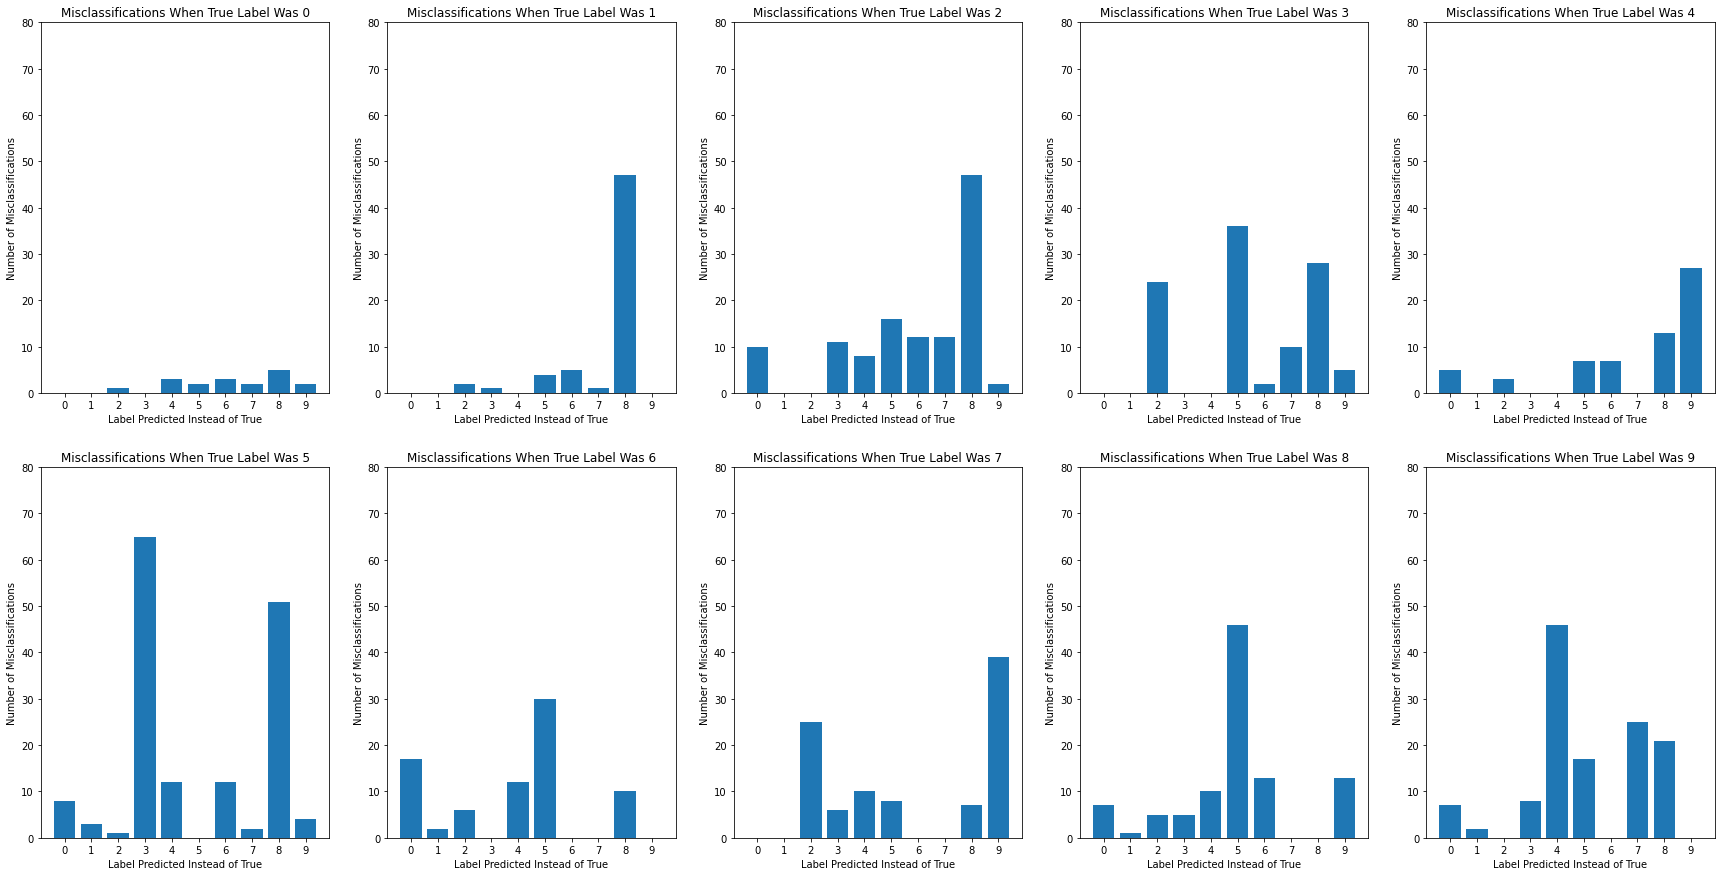

In [ ]:
fig, ax = plt.subplots(2, 5)
fig.set_figheight(15)
fig.set_figwidth(30)


for i in range(0, 5):
    ax[0, i].set_title(f"Misclassifications When True Label Was {i}")
    ax[0, i].set_ylabel("Number of Misclassifications")
    ax[0, i].set_xlabel("Label Predicted Instead of True")
    ax[0, i].set_ylim([0, 80])
    ax[0, i].set_xticks(range(0, 10))

    ax[0, i].bar(range(0, 10), np.bincount(misclassifications.get(i), minlength=10))


for i in range(5, 10):
    ax[1, i-5].set_title(f"Misclassifications When True Label Was {i}")
    ax[1, i-5].set_ylabel("Number of Misclassifications")
    ax[1, i-5].set_xlabel("Label Predicted Instead of True")
    ax[1, i-5].set_ylim([0, 80])
    ax[1, i-5].set_xticks(range(0, 10))

    ax[1, i-5].bar(range(0, 10), np.bincount(misclassifications.get(i), minlength=10))


plt.show()

Here, we can see the same trends as the confusion matrix, but a bit clearer. Our model struggles a lot with predicting 5s, often confusing them with 3s and 8s, and vice versa.

We are also predicting 1s and 2s as 8, although we're not predicting 8s as 1 and 2.

In certain instances, we're also predicting digits that are visually similar.
We're also predicting 5s instead of 6s often, and a decent number of 9s and 4s are getting mixed up.



## The Numbers
---



We've yet to look indepth at the metrics of accuracy, precision and recall of the model. 

First, we'll start with the accuracy of each digit, which unfortunately isn't provided by a neat sklearn function. Instead, we'll get it from the confusion matrix, by dividing the diagonals (the number of true positives) by the total number of labels for each number.

In [ ]:
cf_matr.diagonal()/cf_matr.sum(axis=1)

array([0.98163265, 0.94713656, 0.88565891, 0.8960396 , 0.93686354,
       0.82286996, 0.91962422, 0.90758755, 0.8973306 , 0.87512389])

In the array above, the index corresponds to the digit.

We can see that our accuracy for 5 (82%) is quite bad compared to every other accuracy. This makes sense as we we predicted almost 70 3s and 50 8s instead of 5, so our overall number of true positives for 5 is going to be subpar.

Next, we'll look at our precision and recall scores for each label.

Sklearn provides a great [classification_report function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) that calculates them all for us:

In [ ]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.99      0.95      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.90      0.90      0.90      1010
           4       0.90      0.94      0.92       982
           5       0.82      0.82      0.82       892
           6       0.94      0.92      0.93       958
           7       0.95      0.91      0.93      1028
           8       0.79      0.90      0.84       974
           9       0.91      0.88      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



Our precisions for 5 and 8 are comparatively low: 82% and 79% respectively. So, when we're predicting 5 or 8 for an image, only 82% and 79% of them are actually 5s and 8s. This lowers my certainty in the model that the classification is correct when it returns a 5 or 8.

The only below average recall from the model is of 5 at 82% again. Of the digits labeled 5 in our test set, the model only predicted 82% of them. This tells me the model has some difficulty determining what a 5 should look like.



Overall, the dense neural network can classify relatively well, but has some difficulty especially with the digits 5 and 8.

# Creating the Convolutional Neural Network

---

Hopefully, the convolutional network can better extract features than the dense network due to its convolutional and pooling layers. This should result in less misclassifications of similar digits like what we saw in the dense network.

This model follows the base model found from another TensorFlow tutorial [here](https://www.tensorflow.org/tutorials/images/cnn).

Just like the dense neural network, the input to this model will be our same input images, and our outputs will be arrays of size 10 where each value is the probability of the image being the digit associated with the index.


In [ ]:
c_model = Sequential()
c_model.add(Conv2D(28, (4, 4), activation='relu', input_shape=(28, 28, 1)))
c_model.add(MaxPooling2D((2, 2)))
c_model.add(Conv2D(16, (2, 2), activation='relu'))
c_model.add(MaxPooling2D((2, 2)))
c_model.add(Conv2D(8, (2, 2), activation='relu'))
c_model.add(Flatten())
c_model.add(Dense(16, activation='relu'))
c_model.add(Dense(10, activation='softmax'))

c_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 28)        476       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        1808      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           520       
                                                                 
 flatten_1 (Flatten)         (None, 128)              

Note how this convolutional network has only a fifth of the parameters of the dense one.

In [ ]:
c_model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Just like before, we'll be using Keras' [EarlyStopping callback](https://keras.io/api/callbacks/early_stopping/) to ensure our model is trained the best it can without overfitting:

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

Once again, this is the code to generate the model. We will be loading a model that was trained using this code later, to standardize analysis.

In [ ]:
c_history = c_model.fit(x=x_train, y=y_train,
                    validation_data=(x_valid, y_valid),
                    epochs=50,
                    callbacks=[callback])

Epoch 1/50
1563/1563 [==============================] - 22s 14ms/step - loss: 0.6654 - accuracy: 0.8191 - val_loss: 0.1710 - val_accuracy: 0.9499
Epoch 2/50
1563/1563 [==============================] - 21s 13ms/step - loss: 0.1445 - accuracy: 0.9573 - val_loss: 0.1305 - val_accuracy: 0.9611
Epoch 3/50
1563/1563 [==============================] - 22s 14ms/step - loss: 0.1084 - accuracy: 0.9675 - val_loss: 0.0943 - val_accuracy: 0.9708
Epoch 4/50
1563/1563 [==============================] - 21s 13ms/step - loss: 0.0856 - accuracy: 0.9747 - val_loss: 0.0735 - val_accuracy: 0.9766
Epoch 5/50
1563/1563 [==============================] - 21s 13ms/step - loss: 0.0770 - accuracy: 0.9766 - val_loss: 0.0844 - val_accuracy: 0.9753


In [ ]:
'''
c_model.save("./drive/MyDrive/College/CMSC320/saved_model/cnn", overwrite=True)

hist_df = pd.DataFrame(c_history.history)
with open("./drive/MyDrive/College/CMSC320/saved_model/cnn_history.csv", mode='w') as f:
    hist_df.to_csv(f)
'''

In [ ]:
# Loading pretrained model for standardized results and analysis

c_model = load_model("./drive/MyDrive/College/CMSC320/saved_model/cnn")
c_history = pd.read_csv("./drive/MyDrive/College/CMSC320/saved_model/cnn_history.csv")

# Evaluating Convolutional Neural Network Training


---



313/313 - 1s - loss: 0.0730 - accuracy: 0.9775 - 1s/epoch - 5ms/step


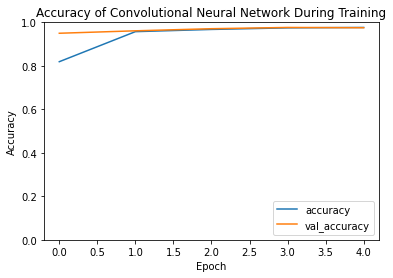

In [ ]:
plt.plot(c_history['accuracy'], label='accuracy')
plt.plot(c_history['val_accuracy'], label = 'val_accuracy')
plt.title("Accuracy of Convolutional Neural Network During Training")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = c_model.evaluate(x_test,  y_test, verbose=2)

Despite having a fifth of the parameters, the accuracy of the convolutional network surpassed that of the dense network during training. This is likely due to convolutional networks' improved ability to extract features from their inputs.

However, you might be able to get the dense network to have similar levels of accuracy, given the appropriate tweaks to the model's hyperparameters and addition of some dropout.

By about the end of the first epoch, accuracy and validation accuracy converged to pretty close to their max values during training. 

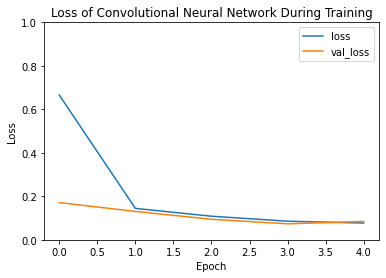

In [ ]:
plt.plot(c_history['loss'], label='loss')
plt.plot(c_history['val_loss'], label = 'val_loss')
plt.title("Loss of Convolutional Neural Network During Training")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.show()

The loss of the convolutional network stayed much smaller than the loss of the dense network. The dense network started with a loss of almost 2, whereas the convolutional network started at less than 1.

# Evaluating Convolutional Neural Network Predictions

---

Just like with the dense network, let's see how it's predictions on the test set vary from the true digits.

In [ ]:
y_test_preds = np.argmax(c_model.predict(x_test), axis=1)

313/313 [==============================] - 2s 5ms/step


Looking at the differences in number of predictions vs number of true labels again:

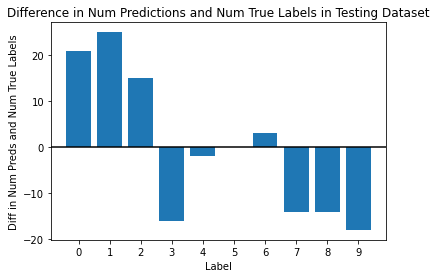

In [ ]:
pred_bincount = np.bincount(y_test_preds)
truth_bincount = np.bincount(y_test)
plt.title("Difference in Num Predictions and Num True Labels in Testing Dataset")
plt.ylabel("Diff in Num Preds and Num True Labels")
plt.xlabel("Label")
plt.gca().axhline(y=0, color="black")
plt.xticks(range(0, 10))
plt.bar(range(0, 10), pred_bincount - truth_bincount)
plt.show()

Again, positive values indicate more predictions than actual labels for that digit.

We've predicted the digit 1 about 25 more occurrences than it actually appears, and also predicted the digits 0 and 2 a bit more as well.

We're also not predicting the digits 3, 7, 8 and 9 as much as we should be.

However, we do have some improvement over the dense network. The dense network predicted the digit 8 about **125** instances more than the true number of 8s.

Our convolutional network does not reach such high differences for any label, which may indicate that that it is performing better.

---
Taking a further look into how we're misclassifying results again, we'll start with a confusion matrix:

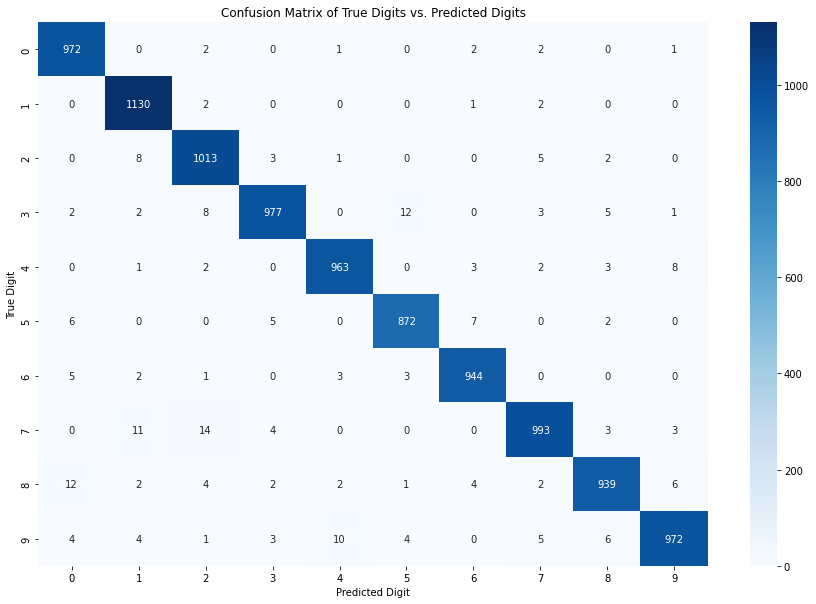

In [ ]:
cf_matr = confusion_matrix(y_test, y_test_preds)

ax = sns.heatmap(cf_matr, annot=True, fmt='0', cmap='Blues')
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(15)

ax.set_ylabel("True Digit")
ax.set_xlabel("Predicted Digit")
ax.set_title("Confusion Matrix of True Digits vs. Predicted Digits")
plt.show()

Compared to the dense network, we have a lot fewer classifications off of the diagonals. Previously, we could identify instances of 50 or more classifications in a category that was not along the diagonal, indicating an incorrect prediction.

With this confusion matrix, the highest instances of misclassifications appear to be:
- 14 predictions of 7 as 2
- 12 predictions of 8 as 0
- 12 predictions of 3 as 5
- 11 predictions of 7 as 1
- 10 predictions of 9 as 4

We'll also look at the misclassifications for each label, to make it clearer:

In [ ]:
misclassifications = {}
for i in range(len(y_test)):
    true_label = y_test[i]
    pred_label = y_test_preds[i]

    if true_label != pred_label:
        misclassifications.setdefault(true_label, [])
        misclassifications.get(true_label).append(pred_label)

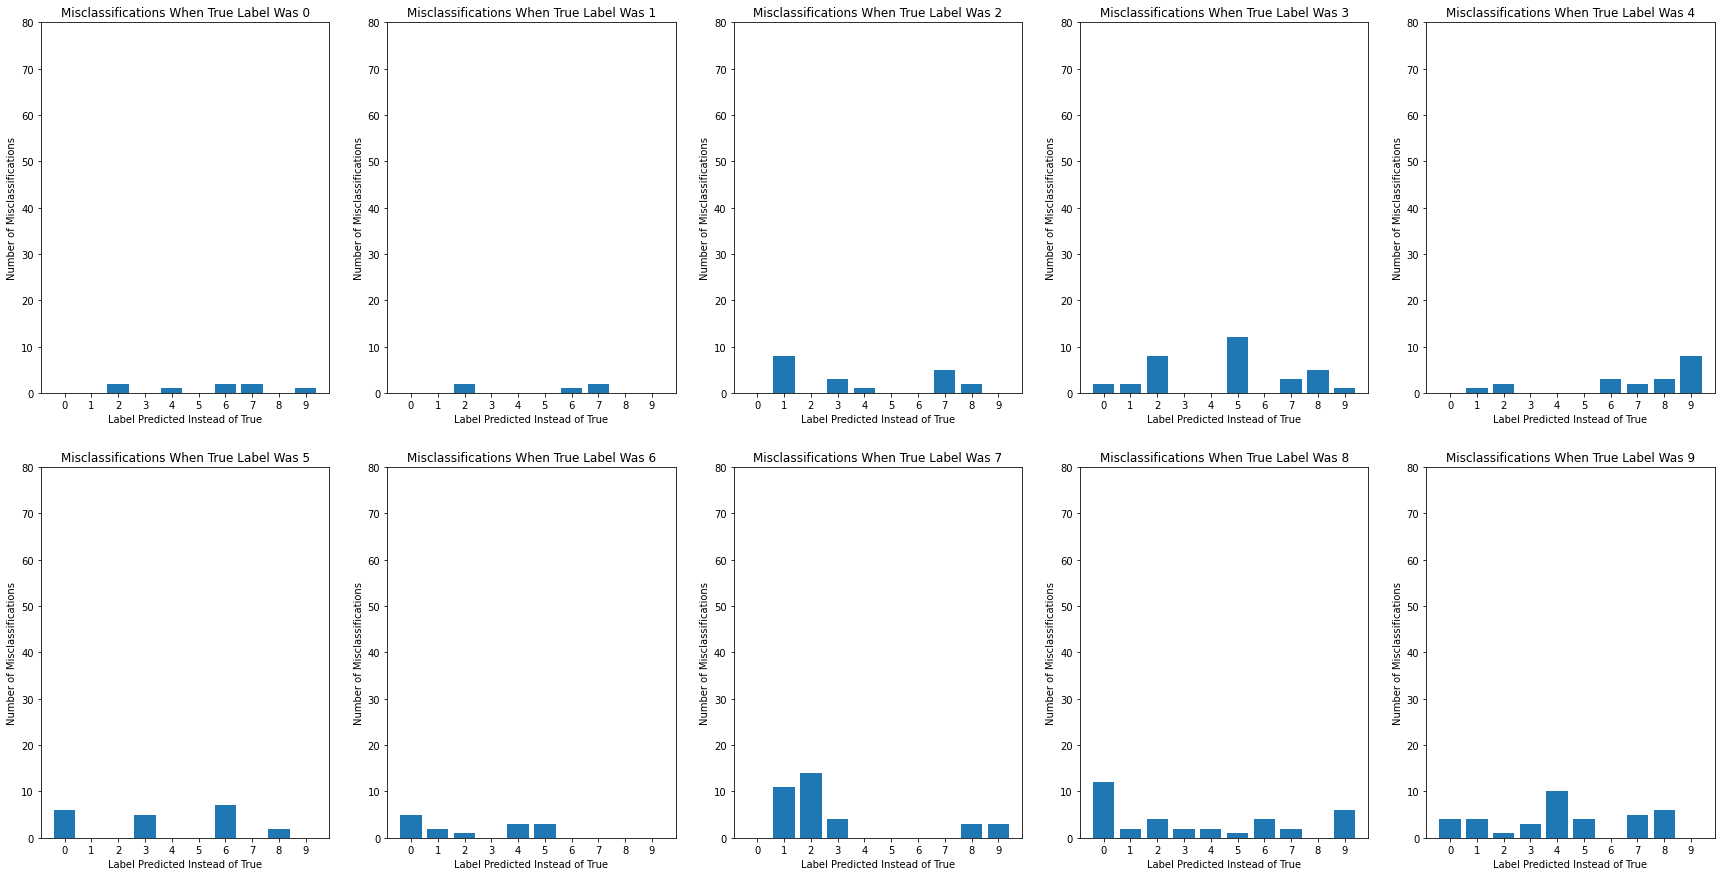

In [ ]:
fig, ax = plt.subplots(2, 5)
fig.set_figheight(15)
fig.set_figwidth(30)


for i in range(0, 5):
    ax[0, i].set_title(f"Misclassifications When True Label Was {i}")
    ax[0, i].set_ylabel("Number of Misclassifications")
    ax[0, i].set_xlabel("Label Predicted Instead of True")
    ax[0, i].set_ylim([0, 80])
    ax[0, i].set_xticks(range(0, 10))

    ax[0, i].bar(range(0, 10), np.bincount(misclassifications.get(i), minlength=10))


for i in range(5, 10):
    ax[1, i-5].set_title(f"Misclassifications When True Label Was {i}")
    ax[1, i-5].set_ylabel("Number of Misclassifications")
    ax[1, i-5].set_xlabel("Label Predicted Instead of True")
    ax[1, i-5].set_ylim([0, 80])
    ax[1, i-5].set_xticks(range(0, 10))

    ax[1, i-5].bar(range(0, 10), np.bincount(misclassifications.get(i), minlength=10))


plt.show()

Here we're using the same scale as what was used for the dense network, to make comparison easy. The convolutional network is definitely misclassifying less often.

With the convolutional network, we don't get anywhere close to the number of misclassifications that the dense network had for many of its labels.

The most significant cases in the convolutional network are when we incorrectly predict a different digit in about 10 instances, whereas the dense network would sometimes incorrectly predict a digit in about 65 instances instead of the true digit.


## The Numbers
---



Following the same pattern as the dense network, we'll now look at our metrics.

Starting with the accuracy again:

In [ ]:
cf_matr.diagonal()/cf_matr.sum(axis=1)

array([0.99183673, 0.99559471, 0.98158915, 0.96732673, 0.98065173,
       0.97757848, 0.98538622, 0.96595331, 0.96406571, 0.96333003])

In the array above, the index corresponds to the digit.

Our accuracy for each digit is quite a bit higher than that of the dense network. Previously, we had some accuracies in the 80-90% range, but the convolutional network has an accuracies greater than 96% for all labels.

The digits the convolutional network has the least accuracy for are 7 and 8 (although their accuracies are ~96%).

Next, we'll look at our precision and recall scores for each label.

Using Sklearn's [classification_report function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) again:

In [ ]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.97      1.00      0.98      1135
           2       0.97      0.98      0.97      1032
           3       0.98      0.97      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.98      0.96      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



The convolutional network also has much greater precision than the dense network. Where the dense network had some precisions in the 82s and 79s, our lowest precision in the convolutional network is 97%. We can be fairly certain that when the model predicts a digit, it is a correct prediction.

The recall of our convolutional network also tells a similar story - the recalls range from 96% to 100%, while the recalls of the dense network were closer to 90%, going as low as 82%. Recalls this high tell us our model is predicting a high number of digits correctly, as the recall is the ratio of true positives to to the total number of positive labels.



# Conclusion

---



The dense network, all things considered, performed fairly well. With accuracies, precisions and recalls ~ 90%, it could predict 0s well, but had difficulties with 5s and 8s.

The convolutional network outperformed the dense network, having accuracies, precisions and recalls of ~ 98%. It has some slight trouble predicting the digit 7, but could still do so better than the dense network.

The convolutional network was able to perform better because of its convolutional layers, which are better suited for extracting features from images than a traditional dense network. Dense networks must rely purely on adjustments during training in order to learn features from images.